In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
from scipy.stats import kruskal
from scipy.stats import ttest_ind, t
import matplotlib.colors as mcolors

Prepare data

In [22]:
df = pd.read_csv('data/Supplementary Data 1.csv')
df = df[df["90%CCM, 91%IB, 97.5%IA_cyano"] == 1] 

df["Form"] = df["Form"].replace("IAc_cyano", "α-cyano")
df["Form"] = df["Form"].replace("IB", "β-cyano")
df["Form"] = df["Form"].replace("IAc_noncyano", "CCM-proteo")

df['Rate mean [s-1]'] = df['Rate mean [s-1]'].astype(float)

df.loc[:,"Form"] = pd.Categorical(df["Form"],
                                   categories=['α-cyano','β-cyano', 'CCM-proteo'],
                                   ordered=True)

my_pal = {"α-cyano":'#90ee90ff', "β-cyano": '#2fad25ff', "CCM-proteo":'#b3cd49ff'}

/var/folders/xl/__300bdj021f6jv0hgdjcrg40000gp/T/ipykernel_59075/1774044196.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,"Form"] = pd.Categorical(df["Form"],


Statistical tests

In [23]:
pop1 = df[df['Form'] == 'α-cyano']['Rate mean [s-1]'].dropna()
pop2 = df[df['Form'] == 'β-cyano']['Rate mean [s-1]'].dropna()
pop3 = df[df['Form'] == 'CCM-proteo']['Rate mean [s-1]'].dropna()

# Kruskal-Wallis test on the three populations
statistic, pvalue = kruskal(pop1, pop2, pop3)

if pvalue < 0.05:
    print(f'Kruskal-Wallis test: At least two populations are significantly different. p = {pvalue}')
else:
    print('Kruskal-Wallis test: All populations are not significantly different')
    

# t-values for each pair of populations
t1, p1 = ttest_ind(pop1, pop2)
t2, p2 = ttest_ind(pop1, pop3)
t3, p3 = ttest_ind(pop2, pop3)

# Calculate critical t-value
alpha = 0.05  # desired level of significance
degfree = len(pop1) + len(pop2) - 2  # degrees of freedom
critical_t = t.ppf(1 - alpha / 2, degfree)  # two-tailed test

# Compare calculated t-values to critical t-value
if abs(t1) > critical_t:
    print(f"Populations 1 and 2 are significantly different. p = {p1}")
if abs(t2) > critical_t:
    print(f"Populations 1 and 3 are significantly different. p = {p2}")
if abs(t3) > critical_t:
    print(f"Populations 2 and 3 are significantly different. p = {p3}")


Kruskal-Wallis test: At least two populations are significantly different. p = 0.0005878773148365399
Populations 1 and 2 are significantly different. p = 0.00014390692738358162
Populations 1 and 3 are significantly different. p = 0.0001820664095941791


Plot

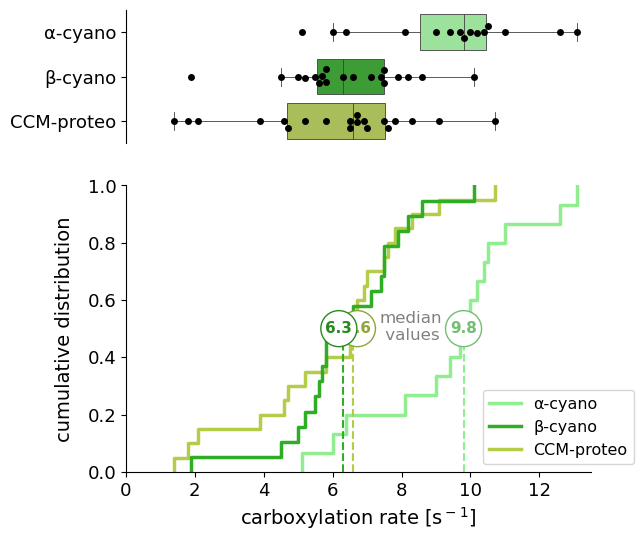

In [24]:
plt.rc('font', size=13) 
   
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 6), gridspec_kw={'height_ratios': [1.4, 3]})

# boxplot/swarmplot on first axis

sns.boxplot(data=df, x='Rate mean [s-1]', y='Form', palette=my_pal, ax=axs[0], showfliers=False, linewidth=0.6)
sns.swarmplot(data=df, x='Rate mean [s-1]', y='Form', color='black', ax=axs[0])

axs[0].set_ylabel('')
axs[0].spines.top.set_visible(False)
axs[0].spines.right.set_visible(False)
axs[0].spines.bottom.set_visible(False)
axs[0].set_xlabel('')
axs[0].set(xticklabels=[])
axs[0].tick_params(bottom=False)
axs[0].set_xlim(0, 13.5)

# cdf on second axis

sns.ecdfplot(data=df, x='Rate mean [s-1]', hue='Form', palette=my_pal, ax=axs[1], linewidth=2.5)

axs[1].spines.top.set_visible(False)
axs[1].spines.right.set_visible(False)
axs[1].set_xlabel('carboxylation rate [s$^-$$^1$]', fontsize=14)
axs[1].set_ylabel('cumulative distribution', fontsize=14, labelpad=10)
axs[1].legend_.set_title("")
sns.move_legend(axs[1], "lower right", prop={'size': 11.5}, bbox_to_anchor=(1.11, 0))
axs[1].set_xlim(0, 13.5)

plt.subplots_adjust(wspace=0.1)

axs[1].text(7.37, 0.46, 'median\n values', fontsize=12, color='grey')

# Find the x-coordinates of the points where the curves cross the y=0.5 line
xcoords = []
xcoords_original = []  # Store the original x-coordinates
for curve in axs[1].get_lines():
    xdata = curve.get_xdata()
    xcoord = np.median([x for x in xdata if x > 0])
    xcoords.append(xcoord)
    xcoords_original.append(xcoord)  # Store the original x-coordinate

# Find the minimum distance between any two markers on the x-axis
min_distance = float('inf')

for i in range(len(xcoords)):
    for j in range(i+1, len(xcoords)):
        distance = abs(xcoords[i] - xcoords[j])
        min_distance = min(min_distance, distance)

# Shift markers that are closer than 1 on the x-axis
for i in range(len(xcoords)):
    for j in range(i+1, len(xcoords)):
        distance = abs(xcoords[i] - xcoords[j])
        if distance < 1:
            if xcoords[i] < xcoords[j]:
                xcoords[i] -= 0.12
                xcoords[j] += 0.12
            else:
                xcoords[i] += 0.12
                xcoords[j] -= 0.12


# Draw vertical lines from the x-axis to the curve at the original x-coordinates
for curve, xcoord, xcoord_original in zip(axs[1].get_lines(), xcoords, xcoords_original):
    ycoord = 0.5
    curve_color = mcolors.to_rgb(curve.get_color())  # Convert color to RGB
    text_color = tuple(np.array(curve_color) * 0.8)  # Darken the color
    axs[1].vlines(xcoord_original, 0, ycoord, color=curve_color, linestyle='dashed')
    # Use the original x-coordinate for the label
    axs[1].annotate(f'{xcoord_original:.1f}', xy=(xcoord, ycoord), xytext=(xcoord, ycoord),
                    color=text_color,
                    ha='center', va='center', fontsize=11, fontweight='bold',
                    bbox=dict(facecolor='white', edgecolor=text_color, boxstyle='circle,pad=0.3'))


plt.savefig(r'plots/acyano_bcyano_CCMproteo.png', dpi=300, bbox_inches='tight')
plt.show()

Summary table

In [25]:
df.loc[:, "Form"] = pd.Categorical(df["Form"],
                                   categories=['α-cyano', 'β-cyano', 'CCM-proteo'],
                                   ordered=True)

df['tested'] = ""

df_count_tested = df.groupby("Form")["tested"].count().reset_index()

df_count_active = df.groupby("Form")["Rate mean [s-1]"].count().reset_index()
df_count_active.rename(columns={'Rate mean [s-1]': 'active'}, inplace=True)

df_count_medianrate = df.groupby("Form")["Rate mean [s-1]"].median().reset_index()
df_count_medianrate.rename(columns={'Rate mean [s-1]': 'median rate'}, inplace=True)

df_count_stdev = df.groupby("Form")["Rate mean [s-1]"].std().reset_index()
df_count_stdev.rename(columns={'Rate mean [s-1]': 'standard deviation'}, inplace=True)

df_count_iqr1 = df.groupby("Form")["Rate mean [s-1]"].quantile(0.25).reset_index()
df_count_iqr1.rename(columns={'Rate mean [s-1]': 'IQR1'}, inplace=True)

df_count_iqr3 = df.groupby("Form")["Rate mean [s-1]"].quantile(0.75).reset_index()
df_count_iqr3.rename(columns={'Rate mean [s-1]': 'IQR3'}, inplace=True)

df_count = pd.merge(df_count_tested, df_count_active, on=['Form'])
df_count = pd.merge(df_count, df_count_medianrate, on=['Form'])
df_count = pd.merge(df_count, df_count_stdev, on=['Form'])
df_count = pd.merge(df_count, df_count_iqr1, on=['Form'])
df_count = pd.merge(df_count, df_count_iqr3, on=['Form'])

df_count['%clustering'] = ["97.5%", "91%", "90%"] 

print(df_count)


         Form  tested  active  median rate  standard deviation   IQR1    IQR3  \
0     α-cyano      19      15          9.8            2.249508  8.550  10.450   
1     β-cyano      29      19          6.3            1.793213  5.550   7.500   
2  CCM-proteo      23      20          6.6            2.417567  4.675   7.525   

  %clustering  
0       97.5%  
1         91%  
2         90%  


/var/folders/xl/__300bdj021f6jv0hgdjcrg40000gp/T/ipykernel_59075/1301827830.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "Form"] = pd.Categorical(df["Form"],
